In [22]:
from datetime import date
from glob import glob

import pandas as pd
from numpy import NaN

In [23]:
%load_ext autoreload
%autoreload 1
%aimport src

from src.misc import get_country_alpha2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Get definitions
%run "00-definitions.ipynb"

## Interpolate installed capacity within the years

Expand the capacity data to the whole year and interpolate for each day.

In [48]:
# Create daily index for the whole period
start_date = START.split()[0]
end_date = END.split()[0]
time_idx = pd.date_range(start_date, end_date, freq='D')

In [62]:
df = pd.read_csv('../data/intermediate/Installed_cap.csv',
                 index_col=0, header=[0,1], parse_dates=True)
installed_capacity = df.reindex(idx).interpolate()

Get only ENTSO-E values as well:

In [61]:
df = pd.read_csv('../data/intermediate/Installed_cap_ENTSO-E_TP.csv',
                 index_col=0, header=[0,1], parse_dates=True)
installed_capacity_entsoe = df.reindex(idx).interpolate()

Example plot

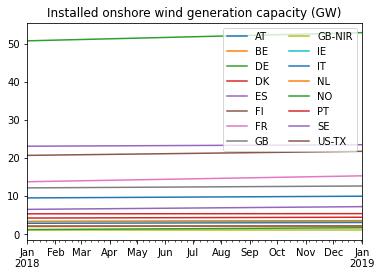

In [51]:
ax = installed_capacity['Wind Onshore'].div(1e3).plot()
ax.set_title("Installed onshore wind generation capacity (GW)");
ax.legend(loc='best', ncol=2);

## Calculation of capacity factors

Calculate capacity factors for each technology based on the interpolated installed capacity on that day.

In [44]:
def calc_cf(category: str, technology: str, installed_capacity: pd.DataFrame):
    src_filepath = f'../data/intermediate/{category.capitalize()} {technology}.csv'
    generation = pd.read_csv(src_filepath, 
                             index_col=0, parse_dates=True)
    cf = pd.DataFrame(index=generation.index)
    for cc in generation.columns:
        gen = generation[cc].dropna()
        try:
            cap = pd.Series(installed_capacity[(tech, cc)], name='cap')
        except KeyError:
            continue
        _df = pd.DataFrame({'gen': gen,
                            'date': pd.DatetimeIndex(gen.index.date)
                           }).join(cap, on='date')
        cf[cc] = _df['gen'] / _df['cap']
        if cf[cc].max() > 1:
            print(f"Too high values for {technology} in {cc}")
            cf[cc] = NaN
    out_filepath = f"../data/intermediate/CF {technology}{(' ' + category) if (category == 'forecast') else ''}.csv"
    cf.dropna(1, how='all').to_csv(out_filepath)
    print(f"Wrote {out_filepath}")

In [45]:
for tech in GEN_TYPES:
    calc_cf('generation', tech, installed_capacity)

Too high values for Solar in IT
Too high values for Solar in PT
Wrote ../data/intermediate/CF Solar.csv
Wrote ../data/intermediate/CF Wind Onshore.csv
Wrote ../data/intermediate/CF Wind Offshore.csv


Try using installed capacity from ENTSO-E for selected regions and techs.

In [68]:
df = installed_capacity.copy()
for col in [('Solar', 'IT'), 
            ('Solar', 'PT')]:
    df[col] = installed_capacity_entsoe[col]
for tech in GEN_TYPES:
    calc_cf('generation', tech, df)

Too high values for Solar in IT
Too high values for Solar in PT
Wrote ../data/intermediate/CF Solar.csv
Wrote ../data/intermediate/CF Wind Onshore.csv
Wrote ../data/intermediate/CF Wind Offshore.csv


In [65]:
for tech in GEN_TYPES:
    calc_cf('forecast', tech, installed_capacity)

Too high values for Solar in PT
Wrote ../data/intermediate/CF Solar forecast.csv
Too high values for Wind Onshore in NL
Too high values for Wind Onshore in SE
Wrote ../data/intermediate/CF Wind Onshore forecast.csv
Too high values for Wind Offshore in BE
Wrote ../data/intermediate/CF Wind Offshore forecast.csv


Try using installed capacity from ENTSO-E for selected regions and techs.

In [67]:
df = installed_capacity.copy()
for col in [('Solar', 'PT'), 
            ('Wind Onshore', 'NL'), 
            ('Wind Onshore', 'SE'),
            ('Wind Offshore', 'BE')]:
    df[col] = installed_capacity_entsoe[col]
for tech in GEN_TYPES:
    calc_cf('forecast', tech, df)

Too high values for Solar in PT
Wrote ../data/intermediate/CF Solar forecast.csv
Too high values for Wind Onshore in NL
Too high values for Wind Onshore in SE
Wrote ../data/intermediate/CF Wind Onshore forecast.csv
Wrote ../data/intermediate/CF Wind Offshore forecast.csv


## Data from other sources

In [69]:
from src.data_cleaning import expand_to_full_length
from src.misc import load_intermediate_data, save_intermediate_data

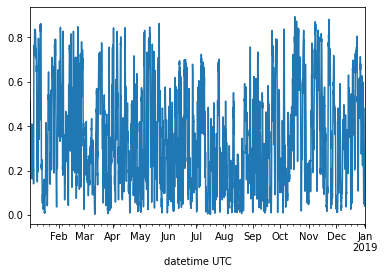

In [70]:
_df = pd.read_excel('../data/external/TASK-25 2018 wind production and load_Quebec.xlsx', 
                                       usecols='A,C,D', skiprows=range(12), index_col=0)
_df.index = pd.to_datetime(_df.index, format='%d%b%Y:%H:%M:%S', utc=True)
_df.columns = ['realized', 'forecast']
cf_wind_onshore_quebeck = _df.copy()
cf_wind_onshore_quebeck['realized'].plot();

In [71]:
cf_wind_onshore = load_intermediate_data('CF Wind Onshore')
cf_wind_onshore['CA-QC'] = cf_wind_onshore_quebeck['realized']
save_intermediate_data(cf_wind_onshore, 'CF Wind Onshore')

In [72]:
cf_wind_onshore_fcast = load_intermediate_data('CF Wind Onshore forecast')
cf_wind_onshore_fcast['CA-QC'] =cf_wind_onshore_quebeck['forecast']
save_intermediate_data(cf_wind_onshore_fcast, 'CF Wind Onshore forecast')